In [3]:
1+1

2

In [4]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# !pip install --quiet tensorflow-hub
# !pip install --quiet seaborn

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [8]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

In [9]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [10]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

Instructions for updating:
Colocations handled automatically by placer.


W0405 12:55:45.813895 140131594917696 deprecation.py:323] From /home/yulia/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
type(embed)

tensorflow_hub.module.Module

In [12]:
main_dir = '/home/yulia/W266-Final-Project/'

In [13]:
data_path = main_dir+'data/raw/hein-daily'

In [14]:
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [15]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 26.1 seconds to create the dictionary


In [16]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

3866201

In [17]:
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94074 ones and 94074 zeroes
Training speech list size: 188148
Training target list size: 188148
Validation split: 31358 ones and 31358 zeroes
Validation speech list size: 62716
Validation target list size: 62716
Test split: 31358 ones and 31358 zeroes
Test speech list size: 62716
Test target list size: 62716


In [18]:
chunk_len=30

In [19]:
reload(preprocess_data)
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)

Original data has 188148 speeches
It was split into 2541572 chunks
Checks on ids and target 2541572 2541572
Original target mean 0.5
New target mean 0.5144335867722811


In [20]:
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)

Original data has 62716 speeches
It was split into 851633 chunks
Checks on ids and target 851633 851633
Original target mean 0.5
New target mean 0.5181163717235007


In [21]:
train_chunk[:2]

['Mr. Speaker. today I join my colleagues. our fellow Americans. and people around the world to offer our prayers to the families of those lost or injured in yesterdays unspeakable',
 'crimes. We stand here in solidarity with the President. who represents this Nation and its resolve to hunt down those responsible and bring them to justice. No one should doubt']

In [22]:
del descr

In [23]:
batches = list(range(0, len(train_chunk), int(len(train_chunk)/10)))
train_emb = np.empty([0,512])

for i in range(len(batches)):
    if i < len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            temp = session.run(embed(train_chunk[batches[i]:batches[i+1]]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))
    if i == len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            temp = session.run(embed(train_chunk[batches[i]:]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))      
    train_emb = np.concatenate((train_emb, temp), axis=0)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:02:23.069400 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 335.6 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:07:48.288657 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 322.6 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:13:10.325346 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 323.6 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:18:38.020271 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 327.8 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:24:17.398830 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 337.3 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:29:53.247094 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 333.4 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:35:33.533809 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 338.0 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:41:16.094871 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 339.1 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:46:56.939590 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 339.6 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:52:47.229255 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 346.3 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0405 13:54:18.895430 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 33.1 seconds to create embeddings


In [24]:
train_emb.shape

(2541572, 512)

In [25]:
del temp

In [26]:
#train_emb.shape

In [27]:
outdata_path = main_dir+'Classification/data/splits/gender'

In [28]:
with open(os.path.join(outdata_path, 'train_target_chunk'), 'wb') as fp:
    pickle.dump(train_target_chunk, fp)
with open(os.path.join(outdata_path, 'val_target_chunk'), 'wb') as fp:
    pickle.dump(val_target_chunk, fp)

In [29]:
with open(os.path.join(outdata_path, 'val_ids_chunk'), 'wb') as fp:
    pickle.dump(val_ids_chunk, fp)

In [30]:
# with open(os.path.join(outdata_path, 'train_target_chunk'), 'rb') as fp:
#     train_target_chunk = pickle.load(fp)
# with open(os.path.join(outdata_path, 'val_target_chunk'), 'rb') as fp:
#     val_target_chunk = pickle.load(fp)

In [35]:
gc.collect()

0

In [34]:
with open(os.path.join(outdata_path, 'train_emb30'), 'wb') as fp:
    pickle.dump(train_emb[:1000000], fp)
with open(os.path.join(outdata_path, 'train_emb30_p2'), 'wb') as fp:
    pickle.dump(train_emb[1000000:2000000], fp)
with open(os.path.join(outdata_path, 'train_emb30_p3'), 'wb') as fp:
    pickle.dump(train_emb[2000000:], fp)

In [ ]:
# with open(os.path.join(outdata_path, 'train_emb30'), 'rb') as fp:
#     train_emb = pickle.load(fp)
# with open(os.path.join(outdata_path, 'train_emb30_p2'), 'rb') as fp:
#     train_emb2 = pickle.load(fp)

In [ ]:
# train_emb = np.concatenate((train_emb, train_emb2), axis=0)
# train_emb.shape

In [36]:
batches = list(range(0, len(val_chunk), int(len(val_chunk)/3)))
val_emb = np.empty([0,512])

for i in range(len(batches)):
    if i < len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            temp = session.run(embed(val_chunk[batches[i]:batches[i+1]]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))
    if i == len(batches) - 1:
        start_time = time.time()
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            temp = session.run(embed(val_chunk[batches[i]:]))
        print("\nIt took {0:.1f} seconds to create embeddings".format(time.time()-start_time))      
    val_emb = np.concatenate((val_emb, temp), axis=0)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0406 00:45:31.961392 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 407.8 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0406 00:52:16.924420 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 403.0 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0406 00:59:06.864733 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 408.0 seconds to create embeddings
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0406 01:00:54.799352 140131594917696 saver.py:1483] Saver not created because there are no variables in the graph to restore



It took 42.0 seconds to create embeddings


In [37]:
val_emb.shape

(851633, 512)

In [38]:
del temp, train, val, test, all_speech_ids, all_speeches, train_chunk, val_chunk

In [39]:
gc.collect()

0

In [40]:
with open(os.path.join(outdata_path, 'val_emb30'), 'wb') as fp:
    pickle.dump(val_emb[:283877], fp)
with open(os.path.join(outdata_path, 'val_emb30_p2'), 'wb') as fp:
    pickle.dump(val_emb[283877:567754], fp)
with open(os.path.join(outdata_path, 'val_emb30_p3'), 'wb') as fp:
    pickle.dump(val_emb[567754:], fp)

In [ ]:
# with open(os.path.join(outdata_path, 'val_emb30'), 'rb') as fp:
#     val_emb = pickle.load(fp)
# with open(os.path.join(outdata_path, 'val_emb30_p2'), 'rb') as fp:
#     val_emb2 = pickle.load(fp)
# with open(os.path.join(outdata_path, 'val_emb30_p3'), 'rb') as fp:
#     val_emb3 = pickle.load(fp)

In [ ]:
# val_emb = np.concatenate((val_emb, val_emb2, val_emb3), axis=0)
# val_emb.shape

In [ ]:
gc.collect()

In [44]:
train_emb[0].shape

(512,)

In [45]:
logs_base_dir = main_dir+"final-project/Classification/logs/gender"

In [46]:
mlp_model_params = {
    'model': 'mlp',
    'learning_rate': 0.001,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 128,
    'dropout_rate': 0.2
}

In [47]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_emb, train_target_chunk), (val_emb, val_target_chunk)), logs_base_dir, **mlp_model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0406 01:04:12.346141 140131594917696 deprecation.py:506] From /home/yulia/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 2541572 samples, validate on 851633 samples
Instructions for updating:
Use tf.cast instead.


W0406 01:04:12.884389 140131594917696 deprecation.py:323] From /home/yulia/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/1000
 - 178s - loss: 0.6555 - acc: 0.6095 - val_loss: 0.6492 - val_acc: 0.6178
Epoch 2/1000
 - 148s - loss: 0.6521 - acc: 0.6143 - val_loss: 0.6477 - val_acc: 0.6199
Epoch 3/1000
 - 151s - loss: 0.6508 - acc: 0.6164 - val_loss: 0.6470 - val_acc: 0.6211
Epoch 4/1000
 - 148s - loss: 0.6502 - acc: 0.6171 - val_loss: 0.6468 - val_acc: 0.6214
Epoch 5/1000
 - 150s - loss: 0.6496 - acc: 0.6177 - val_loss: 0.6457 - val_acc: 0.6227
Epoch 6/1000
 - 150s - loss: 0.6491 - acc: 0.6183 - val_loss: 0.6455 - val_acc: 0.6226
Epoch 7/1000
 - 148s - loss: 0.6488 - acc: 0.6188 - val_loss: 0.6455 - val_acc: 0.6228
Epoch 8/1000
 - 148s - loss: 0.6484 - acc: 0.6192 - val_loss: 0.6452 - val_acc: 0.6234
Epoch 9/1000
 - 147s - loss: 0.6481 - acc: 0.6201 - val_loss: 0.6459 - val_acc: 0.6233
Epoch 10/1000
 - 148s - loss: 0.6478 - acc: 0.6204 - val_loss: 0.6464 - val_acc: 0.6221
Validation accuracy: 0.6220836639404297, loss: 0.6463579719046348


In [48]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target_chunk)

529787

In [68]:
probs_path = main_dir+"Classification/data/probs/gender/"

In [69]:
np.save(probs_path+'val_pred_probs_mlp_use_chunk', val_pred_probs, allow_pickle=True, fix_imports=True)

In [50]:
with open(os.path.join(probs_path, 'val_pred_probs_mlp_use_chunk'), 'wb') as fp:
    pickle.dump(val_pred_probs, fp)

In [51]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs.flatten(), 'preds': val_preds.flatten()})

In [52]:
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000354,0.262059,0.636449,0.437099,0,0.200000,0,0
1,1000000454,0.330816,0.360109,0.345463,0,0.000000,0,0
2,1000000541,0.226093,0.661604,0.403032,0,0.177778,0,0
3,1000000727,0.312327,0.606940,0.499194,0,0.636364,0,1
4,1000000738,0.292938,0.584792,0.465462,0,0.454545,0,0


In [53]:
np.mean(val_target_chunk == val_preds.flatten())

0.6220836909795652

In [54]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean)

0.6774028955928312

In [55]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

0.6670706039926015

In [56]:
original_df = pd.DataFrame({'target_orig': val_target, 'ids': val_ids})
original_df = original_df.merge(pred_aggr_df, on="ids")
original_df.head()

,target_orig,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1,1090179235,0.521554,0.694736,0.587049,1,1.000000,1,1
1,1,1090044795,0.514718,0.694571,0.616921,1,1.000000,1,1
2,1,1020046081,0.463161,0.933303,0.725295,1,0.750000,1,1
3,1,1090124860,0.421073,0.725589,0.611563,1,0.888889,1,1
4,1,1140096300,0.267103,0.675954,0.509501,1,0.500000,1,0


In [57]:
original_df.target_orig.sum(), original_df.target.sum()

(31358, 31358)

In [58]:
val_pred_mlp_use_aggr_chunk = original_df.preds_probs_mean
val_pred_probs_mlp_use_aggr_chunk = original_df.probs_mean

In [67]:
probs_path

'/home/yulia/W266-Final-Project/Classification/data/probs/gender'

In [70]:
np.save(probs_path+'val_pred_probs_mlp_use_aggr_chunk', val_pred_probs_mlp_use_aggr_chunk, allow_pickle=True, fix_imports=True)

Confusion matrix, without normalization
[[22896  8462]
 [11770 19588]]
             precision    recall  f1-score   support

       Male       0.66      0.73      0.69     31358
     Female       0.70      0.62      0.66     31358

avg / total       0.68      0.68      0.68     62716



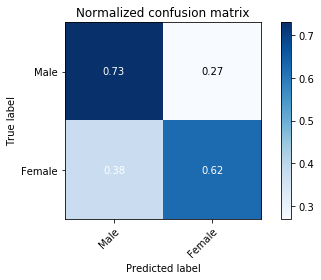

In [62]:
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_probs_mean, classes, normalize=True)

Confusion matrix, without normalization
[[22896  8462]
 [11770 19588]]
             precision    recall  f1-score   support

       Male       0.66      0.73      0.69     31358
     Female       0.70      0.62      0.66     31358

avg / total       0.68      0.68      0.68     62716



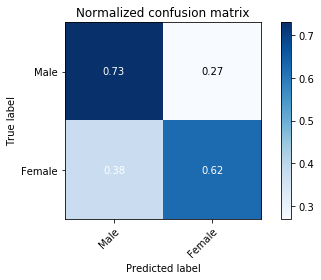

In [63]:
explore_data.plot_confusion_matrix(val_target, val_pred_mlp_use_aggr_chunk, classes, normalize=True)

Confusion matrix, without normalization
[[23505  7853]
 [13027 18331]]
             precision    recall  f1-score   support

       Male       0.64      0.75      0.69     31358
     Female       0.70      0.58      0.64     31358

avg / total       0.67      0.67      0.66     62716



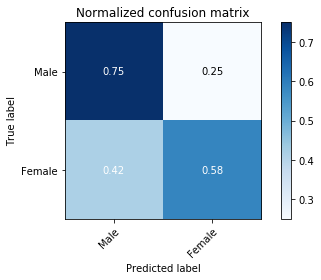

In [64]:
explore_data.plot_confusion_matrix(pred_aggr_df.target, pred_aggr_df.preds_mean, classes, normalize=True)